In [1]:
pip install ensae_teaching_cs

     |████████████████████████████████| 7.0 MB 6.1 MB/s 
     |████████████████████████████████| 49 kB 2.6 MB/s 
     |████████████████████████████████| 2.1 MB 31.8 MB/s 
     |████████████████████████████████| 435 kB 36.9 MB/s 
     |████████████████████████████████| 2.2 MB 22.5 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 2.3 MB 37.5 MB/s 
     |████████████████████████████████| 255 kB 32.9 MB/s 
     |████████████████████████████████| 2.0 MB 36.3 MB/s 
     |████████████████████████████████| 87 kB 2.8 MB/s 
     |████████████████████████████████| 9.4 MB 38.2 MB/s 
     |████████████████████████████████| 208 kB 39.8 MB/s 
     |████████████████████████████████| 126 kB 34.8 MB/s 
     |████████████████████████████████| 81 kB 5.0 MB/s 
  Created wheel for pyensae: filename=pyensae-1.3.884-py3-none-any.whl size=476783 sha256=a12488582f4fadaab4acff8e9a877a2ca3af83d8f679373894b6450c58da5704
  Stored in directory: /root/.cache/pip/wh

In [3]:
pip uninstall numpy

Found existing installation: numpy 1.19.5
Uninstalling numpy-1.19.5:
  Would remove:
    /usr/bin/f2py
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.7
    /usr/local/lib/python3.7/dist-packages/numpy-1.19.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libgfortran-2e0d59d6.so.5.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libopenblasp-r0-09e95953.3.13.so
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libquadmath-2d0c479f.so.0.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/numpy/*
Proceed (y/n)? y
  Successfully uninstalled numpy-1.19.5


In [4]:
pip install river

     |████████████████████████████████| 2.5 MB 5.2 MB/s 
     |████████████████████████████████| 15.7 MB 394 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [18]:
import calendar
import datetime as dt
import math
from river import compose
from river import datasets
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from river import time_series
from ensae_teaching_cs.data import google_trends
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

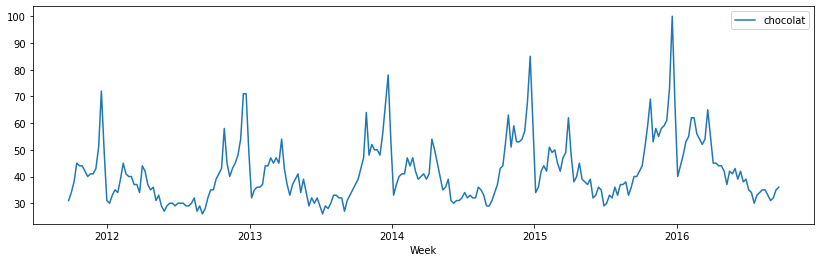

In [22]:
df = pd.read_csv(google_trends("chocolat"), sep=",")
df['Week'] = pd.to_datetime(df['Week'])
df['Week'] = df['Week'].dt.date
df.plot(x="Week", y="chocolat", figsize=(14,4))

In [34]:
df.shape

(261, 2)

In [44]:
predicted_data = []
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

def get_ordinal_date(x):
  timestamp = to_integer(x['Week'])
  return {'ordinal_date': timestamp}

extract_features = compose.TransformerUnion(
  get_ordinal_date
)

model = (
  extract_features |
  time_series.SNARIMAX(
    p=0,
    d=0,
    q=0,
    m=12,
    sp=3,
    sq=6,
    regressor=(
      preprocessing.StandardScaler() |
      linear_model.LinearRegression(
        intercept_init=110,
        optimizer=optim.SGD(0.01),
        intercept_lr=0.3
      )
    )
  )
)

metric = metrics.Rolling(metrics.MAE(), 12)


for x, y in df.iterrows():
  i_date = {'Week': dt.date(year=y['Week'].year, month=y['Week'].month, day=y['Week'].day)}
  y_pred = model.forecast(horizon=1, xs=[i_date])
  model = model.learn_one(i_date, y['chocolat'])
  metric = metric.update(y['chocolat'], y_pred[0])

metric

horizon = 12
future = [
  {'Week': dt.date(i_date['Week'].year,i_date['Week'].month, i_date['Week'].day) + dt.timedelta(days=7*m)}
  for m in range(1, horizon + 1)
]
forecast = model.forecast(horizon=horizon, xs=future)
for x, y_pred in zip(future, forecast):
  predicted_data.append([x['Week'],y_pred])
  print(x['Week'], f'{y_pred:.3f}')

predicted_data = pd.DataFrame(predicted_data, columns=['Week', 'chocolat'])

2016-09-25 33.761
2016-10-02 35.154
2016-10-09 36.054
2016-10-16 36.679
2016-10-23 36.703
2016-10-30 36.266
2016-11-06 37.823
2016-11-13 38.584
2016-11-20 38.104
2016-11-27 35.395
2016-12-04 39.849
2016-12-11 42.287


In [45]:
predicted_data.head()

,Week,chocolat
0,2016-09-25,33.761481
1,2016-10-02,35.153875
2,2016-10-09,36.054375
3,2016-10-16,36.679486
4,2016-10-23,36.703239


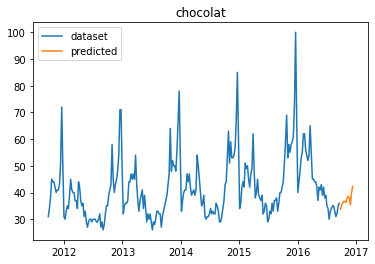

In [46]:
plt.plot(df['Week'],df['chocolat'],label="dataset")
plt.plot(predicted_data['Week'],predicted_data['chocolat'],label="predicted")
plt.title("chocolat")
plt.legend()
plt.show()
